# Diving into the Housing Market

**A few goals of this notebook**
1. Explore the housing data
2. Univariate + Multivariate analysis
3. Crime correlation to price
4. Modelling (Boosted trees vs GLM)

In [1]:
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import lightgbm as lgb
import numpy as np

from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import LabelEncoder


le = LabelEncoder()


import warnings
warnings.filterwarnings('ignore')
sns.set()

df = pd.read_csv('./data/train.csv')
df[:4]

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000


In [ ]:
obj_cols = train.select_dtypes('O').columns
norm_cols = ['GrLivArea','1stFlrSF','LotArea']


log = FunctionTransformer(np.log1p)
oe = OrdinalEncoder()
n_pipe = ColumnTransformer(transformers = [
    ("LogScale", log, norm_cols) , # Numerical
    ("Encoder", oe, obj_cols ), # Categorical 

],
remainder='passthrough')

df_train = pd.DataFrame(n_pipe.fit_transform(train), columns=train.columns)
df_train.fillna(df_train.mean())

X = df_train.drop(columns=['SalePrice'])
X = np.asarray(X).astype('float')

y = df_train['SalePrice']
y = np.asarray(y).astype('float')

X_train,X_test,y_train,y_test = train_test_split(X, y)

# EDA

<AxesSubplot:xlabel='SalePrice'>

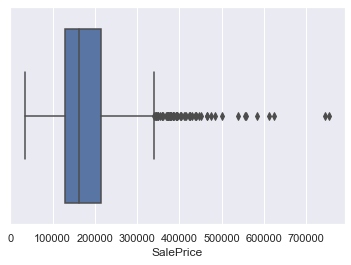

In [2]:
sns.boxplot(df['SalePrice'])

In [3]:
corr = df.corr()

In [4]:
df[['SalePrice','OverallCond']][:1]

,SalePrice,OverallCond
0,208500,5


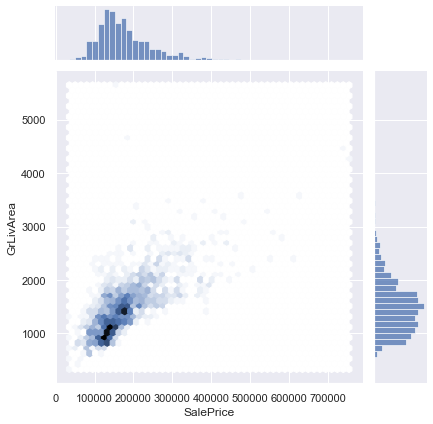

In [5]:
sns.jointplot(x=df['SalePrice'], y=df['GrLivArea'],  kind='hex')

In [6]:
n_cols = df.select_dtypes(['int','float']).columns.tolist()
obj_cols = df.select_dtypes('object').columns.tolist()

# Feat Eng

In [7]:
def feat_eng(frame, cols, test_set = False): 
    
    norm = [ 
        'GrLivArea',
        '1stFlrSF',
        'LotArea',
        ]
        
    if test_set == True:
        pass
    else:
        norm.append('SalePrice')
    
    # Encode Variabels
    for i in cols: 
        frame[i] = frame[i].fillna('None')
        frame[i] = le.fit_transform(frame[i])

    
    # Log normalize vars
    frame[norm] = np.log1p(frame[norm])             


    return frame                       


df = feat_eng(df, obj_cols)
train = df[n_cols+obj_cols]
cols = n_cols + obj_cols

# Train Base Model 

In [8]:
train = train.fillna(train[cols].mean())
train.drop(columns=['Id'], inplace=True)

# Set Training and Test Set

In [9]:
X = train.drop(columns=['SalePrice'])
for i in obj_cols: 
    X[i] = le.fit_transform(X[i])

y = train['SalePrice']
X_train,X_test,y_train,y_test = train_test_split(X,y,train_size=.8)
y_test.reset_index(inplace=True,drop=True)

# Cross Validation
**Test Multiple LR Models**

In [11]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor as lgbm

linear_model = LinearRegression()
rf_model = RandomForestRegressor()
lgb_model = lgbm()

lgb_params = {
    'n_estimators' : [10,15,20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70 , 75,100,200],
    'num_leaves': [2,3,5,7,10,15,20,25,50,75,100],
    'max_depth':[1,2,5,10,15,20,25,50],
    'learning_rate':[.005, .05,.1,.11,.12,.13,.14,.15,.2]
            }

linear_params = {
    'normalize' : [False]
}
            
rf_params = {
    'n_estimators' : [10,15,20, 25,50,75,100,200],    
}

lgb_scores = list()
rf_scores = list()
lr_scores = list()

lgb_best = list()
rf_best = list()
lr_best = list()

models = [lgb_model,]  #  rf_model, linear_model
params = [lgb_params,] #  rf_params, linear_params
scores = [lgb_scores,] #rf_scores, lr_scores
best_params = [lgb_best,]  # rf_best,lr_best

kfold = KFold(n_splits=5, shuffle=True)
for model, parameters, score, best in zip(models, params, scores, best_params):
    print(f'{model}\n \t\t{parameters} \n')
    tuning = GridSearchCV(model, parameters, cv=5, verbose=0) # n_jobs=-1
    best_mod = tuning.fit(X_train,y_train) 
    results = cross_val_score(model, X, y, cv=kfold,)
    score.append(results.mean() * 100)
    best.append(best_mod.best_estimator_.get_params())

final_scores = {'LGBM Regressor' : scores[0], 
                # 'RF Regressor' : scores[1],
                # 'LinearRegresssor' : scores[2]
                }

results = pd.DataFrame(final_scores).T
results.rename(columns={0:'Scores'}, inplace=True)
results['BestParams'] = best_params
results


LGBMRegressor()
 		{'n_estimators': [10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 100, 200], 'num_leaves': [2, 3, 5, 7, 10, 15, 20, 25, 50, 75, 100], 'max_depth': [1, 2, 5, 10, 15, 20, 25, 50], 'learning_rate': [0.005, 0.05, 0.1, 0.11, 0.12, 0.13, 0.14, 0.15, 0.2]} 



,Scores,BestParams
LGBM Regressor,88.427624,"[{'boosting_type': 'gbdt', 'class_weight': Non..."


In [12]:
results['BestParams']['LGBM Regressor']

[{'boosting_type': 'gbdt',
  'class_weight': None,
  'colsample_bytree': 1.0,
  'importance_type': 'split',
  'learning_rate': 0.11,
  'max_depth': 2,
  'min_child_samples': 20,
  'min_child_weight': 0.001,
  'min_split_gain': 0.0,
  'n_estimators': 200,
  'n_jobs': -1,
  'num_leaves': 3,
  'objective': None,
  'random_state': None,
  'reg_alpha': 0.0,
  'reg_lambda': 0.0,
  'silent': 'warn',
  'subsample': 1.0,
  'subsample_for_bin': 200000,
  'subsample_freq': 0}]

In [13]:
feats = results['BestParams']['LGBM Regressor']
model = lgb.LGBMRegressor(
    **feats[0]
)

**Cross Val Score**

In [14]:
kfold = KFold(n_splits=6, shuffle=True)
results = cross_val_score(model, X, y, cv=kfold,)
print(f"Accuracy: {results.mean() * 100}")

Accuracy: 89.13229092082518


# Helper

In [15]:
def fit_models(models, X_train,y_train,X_test): 
    for model in models: 
        model.fit(X_train,y_train)

    d = dict()
    for model in range(len(models)):
        d[model] = models[model].predict(X_test)

    preds = pd.DataFrame(d)
    preds = preds.mean(axis=1)
    return preds


# Fit

# Stack Models

In [16]:
models = [
    lgb.LGBMRegressor(**feats[0]),
    LinearRegression(),
    RandomForestRegressor()
]

In [17]:
preds = fit_models(models,X_train,y_train,X_test)
preds_exp = np.exp(preds)
y_test_exp = np.exp(y_test)
r2_score(y_test, preds)

0.8994975684021439

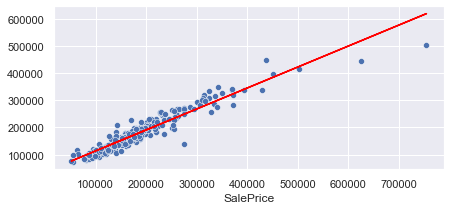

In [18]:
acc = pd.DataFrame({'y_test':y_test_exp, 'preds':preds_exp})
m,b = np.polyfit(acc['y_test'],acc['preds'],1)

fig = plt.figure(figsize=(7,3))
sns.scatterplot(x=y_test_exp,y=preds_exp)
plt.plot(acc['y_test'], m*acc['y_test'] + b, color='red')

# Fit on Entire Dataset

In [19]:
for model in models: 
    model.fit(X,y)

# Cache models on MLFlow

In [76]:
import joblib
import mlflow
from mlflow.models.signature import infer_signature

registry_uri = 'sqlite:///mlflow.db'
tracking_uri = 'http://localhost:5000'

mlflow.tracking.set_registry_uri(registry_uri)
mlflow.tracking.set_tracking_uri(tracking_uri)

names = ['lgbm','LR','RF']
# for model in range(len(models)): 
#     joblib.dump(models[model], f'{names[model]}.joblib')
    

In [77]:
sig1 = infer_signature(X_train, models[0].predict(X_train))
sig2 = infer_signature(X_train, models[1].predict(X_train))
sig3 = infer_signature(X_train, models[2].predict(X_train))

In [78]:
mlflow.set_experiment("mnew")

2022/08/03 21:56:23 INFO mlflow.tracking.fluent: Experiment with name 'mnew' does not exist. Creating a new experiment.


<Experiment: artifact_location='./artifacts/4', experiment_id='4', lifecycle_stage='active', name='mnew', tags={}>

In [84]:
with mlflow.start_run(run_name='train_models') as ml:
    mlflow.lightgbm.log_model(models[0], 'lgbm_house_price',signature=sig1,registered_model_name='test2' )
    # mlflow.sklearn.log_model(models[1], 'LR_model', signature=sig2)
    # mlflow.sklearn.log_model(models[2], 'RF_model', signature=sig3)

Successfully registered model 'test2'.
2022/08/03 21:57:26 INFO mlflow.tracking._model_registry.client: Waiting up to 300 seconds for model version to finish creation.                     Model name: test2, version 1
Created version '1' of model 'test2'.


In [80]:
# mlflow.end_run()

In [81]:
mlflow.lightgbm.load_model(model_uri='models/lgbm_house_price')

OSError: No such file or directory: 'models\lgbm_house_price'

**Apply Feature Engineering to test set**

In [44]:
test = pd.read_csv('./data/test.csv')
test = feat_eng(test, obj_cols, test_set = True)
test.drop(columns=['Id'])
test_cols = [col for col in train.columns if col != 'SalePrice']
test = test.fillna(test[test_cols].mean())

In [45]:
d = dict()
for model in range(len(models)):
    d[model] = models[model].predict(test[test_cols])

preds = pd.DataFrame(d).mean(axis=1)

**Write Out**

In [46]:
values_exp = np.exp(preds)
pd.DataFrame({'Id':test['Id'], 'SalePrice':values_exp}).set_index('Id', drop=True).to_csv('preds.csv')

<AxesSubplot:xlabel='SalePrice', ylabel='Count'>

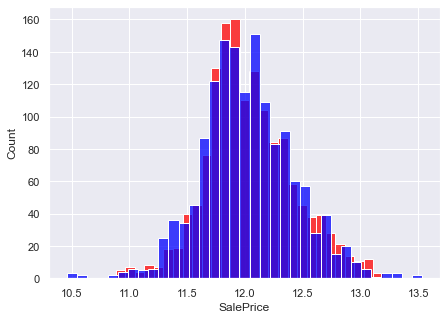

In [47]:
fig,axs = plt.subplots(1,figsize=(7,5))
sns.histplot(preds, color='red')
sns.histplot(train['SalePrice'], color='blue')